In [1]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_excel("Email_Classificaion.xlsx")

In [5]:
data.head()

,Tower Name,Application Name,Email Subject,Flag
0,Core Pharmacy,PharmRDS-Accredo RealTime Messages,Production - Accredo Real Time Order Process S...,Actionable
1,Core Pharmacy,IVR - Web Service,Splunk Alert: SO IVR - Pharmacy Migration Coor...,Actionable
2,Core Pharmacy,ISAM- Web Service,Splunk Alert: ISAM - Slowness,Actionable
3,Core Pharmacy,Migration Co-Ordinaor,Splunk Alert: Migration_Coordinator_500 Clone,Actionable
4,Core Pharmacy,Claim Realm - Web Service,Splunk Alert: Claim Realm Service - Slowness A...,Actionable


In [6]:
data.shape

(73, 4)

In [8]:
data['Flag'].value_counts()

Actionable        48
Non Actionable    18
Name: Flag, dtype: int64

In [10]:
data.isnull().sum()

Tower Name          0
Application Name    0
Email Subject       0
Flag                7
dtype: int64

In [15]:
# ger rid of na values in Flag
data = data[~data['Flag'].isna()]
print(data.shape)
data.head()

(66, 4)


,Tower Name,Application Name,Email Subject,Flag
0,Core Pharmacy,PharmRDS-Accredo RealTime Messages,Production - Accredo Real Time Order Process S...,Actionable
1,Core Pharmacy,IVR - Web Service,Splunk Alert: SO IVR - Pharmacy Migration Coor...,Actionable
2,Core Pharmacy,ISAM- Web Service,Splunk Alert: ISAM - Slowness,Actionable
3,Core Pharmacy,Migration Co-Ordinaor,Splunk Alert: Migration_Coordinator_500 Clone,Actionable
4,Core Pharmacy,Claim Realm - Web Service,Splunk Alert: Claim Realm Service - Slowness A...,Actionable


In [17]:
data['Flag'].value_counts()

Actionable        48
Non Actionable    18
Name: Flag, dtype: int64

In [20]:
print(data["Email Subject"])

0     Production - Accredo Real Time Order Process S...
1     Splunk Alert: SO IVR - Pharmacy Migration Coor...
2                         Splunk Alert: ISAM - Slowness
3         Splunk Alert: Migration_Coordinator_500 Clone
4     Splunk Alert: Claim Realm Service - Slowness A...
                            ...                        
68                    Subject Containing "Failure" word
69                    Subject Containing "Failure" word
70                    Subject Containing "Failure" word
71    Subject Containing "Splunk Alert: Pricing Mart...
72    Subject Containing "Splunk Alert:QVC Kafka - C...
Name: Email Subject, Length: 66, dtype: object


In [25]:
# copy of data
data_copy = data.copy()

### Preprocessing

In [44]:
# Email Subject column
data_copy["Email Subject"] = data_copy["Email Subject"].apply(lambda x: re.sub('[^A-Za-z]'," ",x))
data_copy["Email Subject"] = data_copy["Email Subject"].replace([" ","  ","   "]," ",regex = True)

In [45]:
data_copy["Email Subject"]

0     Production Accredo Real Time Order Process Sta...
1     Splunk Alert SO IVR Pharmacy Migration Coordin...
2                            Splunk Alert ISAM Slowness
3             Splunk Alert Migration Coordinator  Clone
4       Splunk Alert Claim Realm Service Slowness Alert
                            ...                        
68                      Subject Containing Failure word
69                      Subject Containing Failure word
70                      Subject Containing Failure word
71     Subject Containing Splunk Alert Pricing Mart PRD
72    Subject Containing Splunk Alert QVC Kafka Conn...
Name: Email Subject, Length: 66, dtype: object

In [46]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
stopwords = set(STOPWORDS) 

#### Visualise important words in all actionable mails

In [53]:
actionable_doc = " ".join([sent for sent in data_copy.loc[data_copy["Flag"] == "Actionable","Email Subject"]])

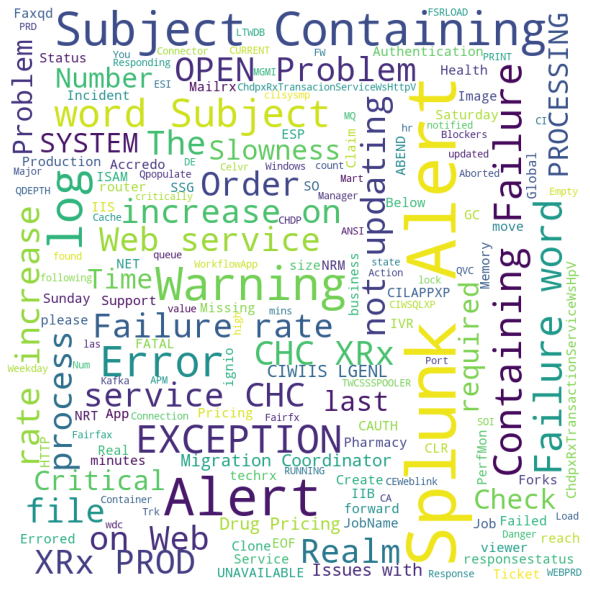

In [57]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocation_threshold = 20).generate(actionable_doc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### Visualise important words in all non-actionable mails


In [55]:
non_actionable_doc = " ".join([sent for sent in data_copy.loc[data_copy["Flag"] == "Non Actionable","Email Subject"]])

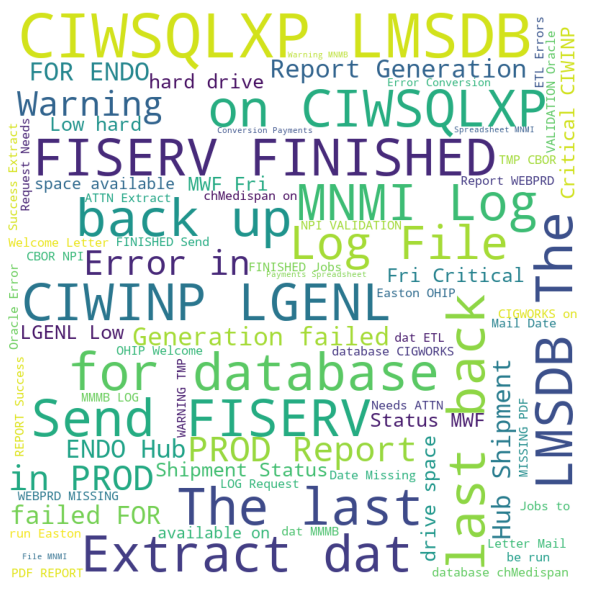

In [56]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocation_threshold = 5).generate(non_actionable_doc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### More Preprocessing

In [70]:
import nltk
from nltk import PorterStemmer
stemmer = PorterStemmer()
data_copy["Email Subject"] = data_copy["Email Subject"].apply(lambda x : x.lower())
data_copy["Email Subject"] = data_copy["Email Subject"].apply(lambda x : " ".join([word for word in x.split() if word not in stopwords]))
data_copy["Email Subject"] = data_copy["Email Subject"].apply(lambda x : stemmer.stem(x))                                                              

### Train Test Split

In [190]:
from sklearn.model_selection import train_test_split
X = data_copy["Email Subject"]
y = data_copy["Flag"].map({"Actionable" : 0, "Non Actionable" : 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Feature Extraction

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,2),max_df = .9,min_df = .05,max_features = 500)
train_data = vectorizer.fit_transform(X_train)

In [195]:
train_data.shape

(46, 32)

In [196]:
type(train_data)

scipy.sparse.csr.csr_matrix

In [197]:
print(train_data[0])

  (0, 23)	0.5962333670739717
  (0, 0)	0.5375979389611433
  (0, 22)	0.5962333670739717


In [200]:
vectorizer.get_feature_names()

['alert',
 'chc',
 'chc xrx',
 'containing',
 'critical',
 'failure',
 'failure rate',
 'fil',
 'increase',
 'increase web',
 'last',
 'log',
 'log fil',
 'open',
 'open problem',
 'problem',
 'problem failure',
 'prod',
 'rate',
 'rate increase',
 'service',
 'service chc',
 'splunk',
 'splunk alert',
 'subject',
 'subject containing',
 'updating',
 'warning',
 'web',
 'web service',
 'xrx',
 'xrx prod']

In [201]:
test_data = vectorizer.transform(X_test)
test_data.shape

(20, 32)

### Modelling

#### Logistic Regression

In [202]:
from sklearn.linear_model import LogisticRegression

In [203]:
logistic_reg_model = LogisticRegression()

In [204]:
logistic_reg_model.fit(train_data,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Training Prediction

In [205]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

prediction_train = logistic_reg_model.predict(train_data)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(prediction_train,y_train))
print("accuracy -- " , accuracy_score(prediction_train,y_train))
print("precision_score -- " , precision_score(prediction_train,y_train))
print("recall_score -- " , recall_score(prediction_train,y_train))
print("f1_score -- " , f1_score(prediction_train,y_train))

---------------Training Result--------------- 
 

[[31  9]
 [ 1  5]]
accuracy --  0.782608695652174
precision_score --  0.35714285714285715
recall_score --  0.8333333333333334
f1_score --  0.5


In [236]:
## if we take observed first then predicted in confusion_matrix then row = observed_y column = predicted_y
print("                       -----------------------------------------------------")
print("                         |  Predicted_negative(0) |  Predicted_positive(1) |")
print("----------------------------------------------------------------------------")
print("| Actual_negative(0)     |          TN            |          FP            |")
print("----------------------------------------------------------------------------")
print("| Actual_positive(1)     |          FN            |          TP            |")
print("----------------------------------------------------------------------------")


print("\n\nRecall = TP / (TP + FN)")
print("Precision = TP / (TP + FP)")

                       -----------------------------------------------------
                         |  Predicted_negative(0) |  Predicted_positive(1) |
----------------------------------------------------------------------------
| Actual_negative(0)     |          TN            |          FP            |
----------------------------------------------------------------------------
| Actual_positive(1)     |          FN            |          TP            |
----------------------------------------------------------------------------


Recall = TP / (TP + FN)
Precision = TP / (TP + FP)


#### Testing Prediction

In [207]:
prediction_test = logistic_reg_model.predict(test_data)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(prediction_test,y_test))    ## here we took prediction_y first so rows of confusion matrix will be prediction and rows are 0 ,1(negetive,positive) ,[[TN,FN] , [FP,TN]
print("accuracy -- " , accuracy_score(prediction_test,y_test))  
print("precision_score -- " , precision_score(prediction_test,y_test))
print("recall_score -- " , recall_score(prediction_test,y_test))
print("f1_score -- " , f1_score(prediction_test,y_test))

---------------Testing Result--------------- 
 

[[15  4]
 [ 1  0]]
accuracy --  0.75
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


In [208]:
print(confusion_matrix(y_test,prediction_test))   ## here we took observed_y first so rows of confusion matrix will be actual and rows are 0 ,1(negetive,positive) ,[[TN,FP] , [FN,TN] 
print(recall_score(y_test,prediction_test))

[[15  1]
 [ 4  0]]
0.0


#### Naive Bayes Classifier

In [209]:
from sklearn.naive_bayes import ComplementNB

In [211]:
simple_naive_bayes = ComplementNB()
simple_naive_bayes.fit(train_data,y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [212]:
prediction_simple_bayes_train = simple_naive_bayes.predict(train_data)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(y_train,prediction_simple_bayes_train))
print("accuracy -- " , accuracy_score(y_train,prediction_simple_bayes_train))
print("precision_score -- " , precision_score(y_train,prediction_simple_bayes_train))
print("recall_score -- " , recall_score(y_train,prediction_simple_bayes_train))
print("f1_score -- " , f1_score(y_train,prediction_simple_bayes_train))

---------------Training Result--------------- 
 

[[25  7]
 [ 7  7]]
accuracy --  0.6956521739130435
precision_score --  0.5
recall_score --  0.5
f1_score --  0.5


In [226]:
prediction_simple_bayes_test = simple_naive_bayes.predict(test_data)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(y_test,prediction_simple_bayes_test))
print("accuracy -- " , accuracy_score(y_test,prediction_simple_bayes_test))
print("precision_score -- " , precision_score(y_test,prediction_simple_bayes_test))
print("recall_score -- " , recall_score(y_test,prediction_simple_bayes_test))
print("f1_score -- " , f1_score(y_test,prediction_simple_bayes_test))

---------------Testing Result--------------- 
 

[[14  2]
 [ 2  2]]
accuracy --  0.8
precision_score --  0.5
recall_score --  0.5
f1_score --  0.5


#### Bernouli Bayes Classifier

In [217]:
from sklearn.naive_bayes import BernoulliNB

In [218]:
simple_naive_bayes1 = BernoulliNB()
simple_naive_bayes1.fit(train_data,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [219]:
prediction_simple_bayes_train1 = simple_naive_bayes1.predict(train_data)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(y_train,prediction_simple_bayes_train1))
print("accuracy -- " , accuracy_score(y_train,prediction_simple_bayes_train1))
print("precision_score -- " , precision_score(y_train,prediction_simple_bayes_train1))
print("recall_score -- " , recall_score(y_train,prediction_simple_bayes_train1))
print("f1_score -- " , f1_score(y_train,prediction_simple_bayes_train1))

---------------Training Result--------------- 
 

[[19 13]
 [ 0 14]]
accuracy --  0.717391304347826
precision_score --  0.5185185185185185
recall_score --  1.0
f1_score --  0.6829268292682926


In [225]:
prediction_simple_bayes_test1 = simple_naive_bayes1.predict(test_data)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(y_test,prediction_simple_bayes_test1))
print("accuracy -- " , accuracy_score(y_test,prediction_simple_bayes_test1))
print("precision_score -- " , precision_score(y_test,prediction_simple_bayes_test1))
print("recall_score -- " , recall_score(y_test,prediction_simple_bayes_test1))
print("f1_score -- " , f1_score(y_test,prediction_simple_bayes_test1))

---------------Testing Result--------------- 
 

[[10  6]
 [ 0  4]]
accuracy --  0.7
precision_score --  0.4
recall_score --  1.0
f1_score --  0.5714285714285715


#### Random Forest Classifier

In [222]:
from sklearn.ensemble import RandomForestClassifier

In [224]:
rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 3)
rf_classifier.fit(train_data,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [227]:
prediction_rf_train = rf_classifier.predict(train_data)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(y_train,prediction_rf_train))
print("accuracy -- " , accuracy_score(y_train,prediction_rf_train))
print("precision_score -- " , precision_score(y_train,prediction_rf_train))
print("recall_score -- " , recall_score(y_train,prediction_rf_train))
print("f1_score -- " , f1_score(y_train,prediction_rf_train))

---------------Training Result--------------- 
 

[[32  0]
 [ 8  6]]
accuracy --  0.8260869565217391
precision_score --  1.0
recall_score --  0.42857142857142855
f1_score --  0.6


In [228]:
prediction_rf_test = rf_classifier.predict(test_data)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(y_test,prediction_rf_test))
print("accuracy -- " , accuracy_score(y_test,prediction_rf_test))
print("precision_score -- " , precision_score(y_test,prediction_rf_test))
print("recall_score -- " , recall_score(y_test,prediction_rf_test))
print("f1_score -- " , f1_score(y_test,prediction_rf_test))

---------------Testing Result--------------- 
 

[[15  1]
 [ 4  0]]
accuracy --  0.75
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


### Fine Tuning

### Building Pipeline

#### Random Forest

In [237]:
from sklearn.pipeline import Pipeline

In [275]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier()),
])

params = {"tfidf__ngram_range" : [(1,2),(1,1)],
         "tfidf__max_df" : [4,5,6,7,8],
         "tfidf__min_df" : [1,2,3],
         "tfidf__max_features" : [50,100,150,200],
         "rf_clf__n_estimators" : [100,200,400],
         "rf_clf__max_depth": [2,3,4],
         "rf_clf__min_samples_split" : [2,3,4,5]}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline,param_grid= params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(X_train,y_train)

Performing grid search...
pipeline: ['tfidf', 'rf_clf']
parameters:
{'tfidf__ngram_range': [(1, 2), (1, 1)], 'tfidf__max_df': [4, 5, 6, 7, 8], 'tfidf__min_df': [1, 2, 3], 'tfidf__max_features': [50, 100, 150, 200], 'rf_clf__n_estimators': [100, 200, 400], 'rf_clf__max_depth': [2, 3, 4], 'rf_clf__min_samples_split': [2, 3, 4, 5]}
Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__ngram_range': [(1, 2), (1, 1)], 'tfidf__max_df': [4, 5, 6, 7, 8], 'tfidf__min_df': [1, 2, 3], 'tfidf__max_features': [50, 100, 150, 200], 'rf_clf__n_estimators': [100, 200, 400], 'rf_clf__max_depth': [2, 3, 4], 'rf_clf__min_samples_split': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [276]:
best_rf_clf = grid_search.best_estimator_
best_rf_clf

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=7, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [277]:
best_rf_clf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=7, max_features=50, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [278]:
prediction_best_rf_train = best_rf_clf.predict(X_train)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(y_train,prediction_best_rf_train))
print("accuracy -- " , accuracy_score(y_train,prediction_best_rf_train))
print("precision_score -- " , precision_score(y_train,prediction_best_rf_train))
print("recall_score -- " , recall_score(y_train,prediction_best_rf_train))
print("f1_score -- " , f1_score(y_train,prediction_best_rf_train))

---------------Training Result--------------- 
 

[[32  0]
 [12  2]]
accuracy --  0.7391304347826086
precision_score --  1.0
recall_score --  0.14285714285714285
f1_score --  0.25


In [279]:
prediction_best_rf_test = best_rf_clf.predict(X_test)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(y_test,prediction_best_rf_test))
print("accuracy -- " , accuracy_score(y_test,prediction_best_rf_test))
print("precision_score -- " , precision_score(y_test,prediction_best_rf_test))
print("recall_score -- " , recall_score(y_test,prediction_best_rf_test))
print("f1_score -- " , f1_score(y_test,prediction_best_rf_test))

---------------Testing Result--------------- 
 

[[16  0]
 [ 4  0]]
accuracy --  0.8
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### SVM pipeline

In [261]:
from sklearn.svm import LinearSVC

In [269]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm_clf', LinearSVC()),
])

params = {"tfidf__ngram_range" : [(1,2),(1,1)],
         "tfidf__max_df" : [4,5,6,7,8],
         "tfidf__min_df" : [1,2,3],
         "tfidf__max_features" : [50,100,150,200],
         'svm_clf__max_iter': (200,400,500,1000),
         "svm_clf__C" : (.001,.005,.01,.02,.05,1)}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline,param_grid= params, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)
grid_search.fit(X_train,y_train)

Performing grid search...
pipeline: ['tfidf', 'svm_clf']
parameters:
{'tfidf__ngram_range': [(1, 2), (1, 1)], 'tfidf__max_df': [4, 5, 6, 7, 8], 'tfidf__min_df': [1, 2, 3], 'tfidf__max_features': [50, 100, 150, 200], 'svm_clf__max_iter': (200, 400, 500, 1000), 'svm_clf__C': (0.001, 0.005, 0.01, 0.02, 0.05, 1)}
Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1762 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 4762 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:   41.8s finished
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__ngram_range': [(1, 2), (1, 1)], 'tfidf__max_df': [4, 5, 6, 7, 8], 'tfidf__min_df': [1, 2, 3], 'tfidf__max_features': [50, 100, 150, 200], 'svm_clf__max_iter': (200, 400, 500, 1000), 'svm_clf__C': (0.001, 0.005, 0.01, 0.02, 0.05, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [270]:
best_svm_clf = grid_search.best_estimator_
best_svm_clf

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=5, max_features=100, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...max_iter=200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [271]:
best_svm_clf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=5, max_features=100, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...max_iter=200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [272]:
prediction_best_svm_train = best_svm_clf.predict(X_train)

print("---------------Training Result--------------- \n \n")
print(confusion_matrix(y_train,prediction_best_svm_train))
print("accuracy -- " , accuracy_score(y_train,prediction_best_svm_train))
print("precision_score -- " , precision_score(y_train,prediction_best_svm_train))
print("recall_score -- " , recall_score(y_train,prediction_best_svm_train))
print("f1_score -- " , f1_score(y_train,prediction_best_svm_train))

---------------Training Result--------------- 
 

[[32  0]
 [ 2 12]]
accuracy --  0.9565217391304348
precision_score --  1.0
recall_score --  0.8571428571428571
f1_score --  0.923076923076923


In [273]:
prediction_best_svm_test = best_svm_clf.predict(X_test)

print("---------------Testing Result--------------- \n \n")
print(confusion_matrix(y_test,prediction_best_svm_test))
print("accuracy -- " , accuracy_score(y_test,prediction_best_svm_test))
print("precision_score -- " , precision_score(y_test,prediction_best_svm_test))
print("recall_score -- " , recall_score(y_test,prediction_best_svm_test))
print("f1_score -- " , f1_score(y_test,prediction_best_svm_test))

---------------Testing Result--------------- 
 

[[13  3]
 [ 2  2]]
accuracy --  0.75
precision_score --  0.4
recall_score --  0.5
f1_score --  0.4444444444444445


In [525]:
# MODEL TRAINING FUNCTION
def train(X_tr,X_te,y_tr,y_te):
    
    ##### random forest classifier
    
   
    rf_clf = RandomForestClassifier()


    params = {"n_estimators" : [100,200,400],
             "max_depth": [2,3,4],
             "min_samples_split" : [2,3,4,5],
             "class_weight" : ["balanced", "balanced_subsample", None]}

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(rf_clf,param_grid= params, n_jobs=-1, verbose=1)

    grid_search.fit(X_tr,y_tr)
    
    best_rf_clf = grid_search.best_estimator_
    print("best rf features -- \n",best_rf_clf)
    print("\n")
    best_rf_clf.fit(X_tr,y_tr)

    ## prediction
    prediction_best_rf_train = best_rf_clf.predict(X_tr)

    print("---------------Training Result Random Forest--------------- \n \n")
    print(confusion_matrix(y_tr,prediction_best_rf_train))
    print("accuracy -- " , accuracy_score(y_tr,prediction_best_rf_train))
    print("precision_score -- " , precision_score(y_tr,prediction_best_rf_train))
    print("recall_score -- " , recall_score(y_tr,prediction_best_rf_train))
    print("f1_score -- " , f1_score(y_tr,prediction_best_rf_train))

    prediction_best_rf_test = best_rf_clf.predict(X_te)

    print("---------------Testing Result Random Forest--------------- \n \n")
    print(confusion_matrix(y_te,prediction_best_rf_test))
    print("accuracy -- " , accuracy_score(y_te,prediction_best_rf_test))
    print("precision_score -- " , precision_score(y_te,prediction_best_rf_test))
    print("recall_score -- " , recall_score(y_te,prediction_best_rf_test))
    print("f1_score -- " , f1_score(y_te,prediction_best_rf_test))


    print("\n\n")
    ####### SVM classification

    svm_clf = LinearSVC()


    params = {'max_iter': (200,400,500,1000),
             "C" : (.001,.002,.005,.009,.01,.02,.05,1),
             "class_weight" : [None,'balanced']}

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(svm_clf,param_grid= params, n_jobs=-1, verbose=1)

   
    grid_search.fit(X_tr,y_tr)

    best_svm_clf = grid_search.best_estimator_
    print("best svm features -- \n",best_svm_clf)
    print("\n")
    
    best_svm_clf.fit(X_tr,y_tr)

    ## prediction

    prediction_best_svm_train = best_svm_clf.predict(X_tr)

    print("---------------Training Result SVM--------------- \n \n")
    print(confusion_matrix(y_tr,prediction_best_svm_train))
    print("accuracy -- " , accuracy_score(y_tr,prediction_best_svm_train))
    print("precision_score -- " , precision_score(y_tr,prediction_best_svm_train))
    print("recall_score -- " , recall_score(y_tr,prediction_best_svm_train))
    print("f1_score -- " , f1_score(y_tr,prediction_best_svm_train))

    prediction_best_svm_test = best_svm_clf.predict(X_te)

    print("---------------Testing Result SVM--------------- \n \n")
    print(confusion_matrix(y_te,prediction_best_svm_test))
    print("accuracy -- " , accuracy_score(y_te,prediction_best_svm_test))
    print("precision_score -- " , precision_score(y_te,prediction_best_svm_test))
    print("recall_score -- " , recall_score(y_te,prediction_best_svm_test))
    print("f1_score -- " , f1_score(y_te,prediction_best_svm_test))

#### Xgboost

In [336]:
from xgboost import XGBClassifier

xg_clf = XGBClassifier()
xg_clf.fit(train_data,y_train)

## prediction

prediction_xg_train = xg_clf.predict(train_data)

print("---------------Training Result Xgboost--------------- \n \n")
print(confusion_matrix(y_train,prediction_xg_train))
print("accuracy -- " , accuracy_score(y_train,prediction_xg_train))
print("precision_score -- " , precision_score(y_train,prediction_xg_train))
print("recall_score -- " , recall_score(y_train,prediction_xg_train))
print("f1_score -- " , f1_score(y_train,prediction_xg_train))

prediction_xg_test = xg_clf.predict(test_data)

print("---------------Testing Result Xgboost--------------- \n \n")
print(confusion_matrix(y_test,prediction_xg_test))
print("accuracy -- " , accuracy_score(y_test,prediction_xg_test))
print("precision_score -- " , precision_score(y_test,prediction_xg_test))
print("recall_score -- " , recall_score(y_test,prediction_xg_test))
print("f1_score -- " , f1_score(y_test,prediction_xg_test))

---------------Training Result Xgboost--------------- 
 

[[31  1]
 [11  3]]
accuracy --  0.7391304347826086
precision_score --  0.75
recall_score --  0.21428571428571427
f1_score --  0.3333333333333333
---------------Testing Result Xgboost--------------- 
 

[[16  0]
 [ 4  0]]
accuracy --  0.8
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## New feature Extraction

### Word Embedding

In [274]:
import gensim

In [320]:
train_tokenized_mails = X_train.apply(lambda x : x.split()).reset_index(drop= 'first')
model_w2v = gensim.models.Word2Vec(train_tokenized_mails,
                      size = 50,
                      window = 3,
                      min_count = 2,
                      sg = 1,
                      negative = 5,
                      workers = 4,
                      seed = 34)

model_w2v.train(train_tokenized_mails, total_examples= len(X_train), epochs=20)

(766, 5520)

In [321]:
model_w2v["alert"].shape

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(50,)

In [322]:
def word_embedding_feature(tokenized_data):
    wordvec_arrays = np.zeros((len(tokenized_data), 50)) 
    
    for i in range(len((tokenized_data))):
        size = len(tokenized_data[i])
        aggregated_wv = np.zeros(50)

        for word in tokenized_data[i]:
            try:
                aggregated_wv += model_w2v[word]
            except:
                aggregated_wv += np.zeros(50)

        aggregated_wv = aggregated_wv / size
        wordvec_arrays[i] = aggregated_wv
    return pd.DataFrame(wordvec_arrays) 

train_wordvec_df = word_embedding_feature(train_tokenized_mails)

train_wordvec_df

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.000187,0.000084,-0.001917,-0.001401,0.002270,-0.000036,-0.000426,-0.002160,-0.000185,-0.000128,...,0.000914,-0.001154,-0.001746,-0.001933,0.000625,-0.000365,0.003148,-0.000024,-0.000642,-0.000770
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.001191,-0.001670,-0.003430,-0.004821,0.004777,-0.001038,-0.001032,-0.003450,-0.002262,-0.000963,...,0.000415,-0.000580,-0.001781,-0.002091,-0.000321,-0.002923,0.003028,-0.002309,-0.000233,0.001239
3,-0.000935,0.002386,0.004287,0.002760,0.001629,-0.003893,0.002399,0.000483,0.002821,0.000771,...,0.000193,-0.001306,-0.003621,-0.001882,-0.001724,-0.002990,-0.001160,-0.001980,0.002822,-0.002693
4,-0.002068,0.000368,-0.000831,0.000575,0.000240,-0.000604,0.002366,-0.000888,-0.001637,0.000240,...,0.002052,-0.000439,0.003053,-0.003057,0.002044,0.000583,-0.002653,0.000856,0.000300,0.001839
5,0.001444,0.000155,-0.001465,-0.000578,0.003367,0.000100,0.000081,-0.002948,-0.000853,-0.000134,...,-0.001324,0.001214,0.001585,-0.002083,-0.002173,-0.000329,0.001634,-0.000201,-0.000355,-0.000773
6,0.001546,0.006688,-0.004113,-0.001332,-0.000957,0.000871,0.004098,0.000193,0.001653,-0.002143,...,0.001930,-0.000221,0.001319,-0.009513,0.007006,-0.002466,0.003151,0.000949,0.002795,0.008726
7,0.000162,0.004007,-0.002637,0.000653,0.001957,0.002731,0.002576,0.000372,0.003790,0.003177,...,0.003516,0.003525,0.000785,-0.000618,-0.001593,0.001269,0.002478,-0.002566,0.002228,0.003344
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,-0.000701,0.001789,0.003215,0.002070,0.001222,-0.002920,0.001799,0.000362,0.002116,0.000578,...,0.000145,-0.000980,-0.002715,-0.001412,-0.001293,-0.002243,-0.000870,-0.001485,0.002117,-0.002020


In [323]:
test_tokenized_mails = X_test.apply(lambda x : x.split()).reset_index(drop= 'first')
test_wordvec_df = word_embedding_feature(test_tokenized_mails)

test_wordvec_df

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.001072,0.002249,-0.000841,-0.000804,0.000299,-0.000374,0.001813,-0.000981,0.000869,0.000109,...,0.002060,0.002202,0.000579,-0.000738,-0.000665,0.000613,0.000511,-0.001735,0.000209,0.001526
1,0.002437,0.005144,0.000825,0.006030,-0.003624,0.002329,-0.004122,0.002291,0.002167,-0.005716,...,-0.003270,-0.001148,0.004870,-0.000018,-0.001135,-0.001458,-0.001753,0.003365,0.000910,0.003381
2,0.000898,0.000966,-0.000077,-0.000867,-0.000227,-0.001010,0.000942,-0.000951,-0.000187,-0.000699,...,0.000923,0.001046,0.000310,-0.000491,-0.000184,0.000219,-0.000172,-0.000877,-0.000374,0.000499
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000978,0.001386,-0.002339,-0.002790,0.002345,-0.001389,0.000759,-0.003788,-0.000465,-0.001081,...,0.002298,0.000048,-0.001623,-0.002910,0.000483,-0.000134,0.003443,-0.001197,-0.001247,-0.000232
5,0.002437,0.005144,0.000825,0.006030,-0.003624,0.002329,-0.004122,0.002291,0.002167,-0.005716,...,-0.003270,-0.001148,0.004870,-0.000018,-0.001135,-0.001458,-0.001753,0.003365,0.000910,0.003381
6,0.000171,0.001583,0.001590,-0.000588,0.000255,-0.000055,0.000012,-0.000628,-0.000432,-0.001656,...,0.001078,0.001601,-0.000927,-0.001731,-0.000638,0.001315,-0.000753,-0.000870,-0.000282,0.000615
7,0.000729,-0.001086,-0.002501,-0.002477,0.001301,-0.002445,-0.001632,-0.001665,-0.000504,-0.002329,...,-0.000773,0.001209,-0.001767,-0.000789,-0.001077,-0.001461,0.002812,-0.001968,0.000171,0.002166
8,0.001163,0.001981,-0.003325,-0.001312,0.000611,-0.000026,-0.000211,-0.002463,0.000054,-0.001103,...,-0.000379,0.001025,0.000290,-0.000988,-0.001342,0.000024,0.002062,-0.000699,-0.002164,0.001058
9,0.000547,-0.000814,-0.001876,-0.001857,0.000976,-0.001833,-0.001224,-0.001248,-0.000378,-0.001747,...,-0.000580,0.000907,-0.001325,-0.000592,-0.000807,-0.001096,0.002109,-0.001476,0.000128,0.001625


In [ ]:
### Training with pipeline

In [329]:
train(train_wordvec_df,test_wordvec_df,y_train,y_test)

C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   12.6s finished
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


---------------Training Result Random Forest--------------- 
 

[[32  0]
 [ 2 12]]
accuracy --  0.9565217391304348
precision_score --  1.0
recall_score --  0.8571428571428571
f1_score --  0.923076923076923
---------------Testing Result Random Forest--------------- 
 

[[16  0]
 [ 4  0]]
accuracy --  0.8
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0



Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


---------------Training Result SVM--------------- 
 

[[32  0]
 [14  0]]
accuracy --  0.6956521739130435
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0
---------------Testing Result SVM--------------- 
 

[[16  0]
 [ 4  0]]
accuracy --  0.8
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.6s finished
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred

#### Xgboost

In [330]:
from xgboost import XGBClassifier

C:\Users\Chayan\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Chayan\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Chayan\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [331]:
xg_clf = XGBClassifier()

In [332]:
xg_clf.fit(train_wordvec_df,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [335]:
## prediction

prediction_xg_train = xg_clf.predict(train_wordvec_df)

print("---------------Training Result Xgboost--------------- \n \n")
print(confusion_matrix(y_train,prediction_xg_train))
print("accuracy -- " , accuracy_score(y_train,prediction_xg_train))
print("precision_score -- " , precision_score(y_train,prediction_xg_train))
print("recall_score -- " , recall_score(y_train,prediction_xg_train))
print("f1_score -- " , f1_score(y_train,prediction_xg_train))

prediction_xg_test = xg_clf.predict(test_wordvec_df)

print("---------------Testing Result Xgboost--------------- \n \n")
print(confusion_matrix(y_test,prediction_xg_test))
print("accuracy -- " , accuracy_score(y_test,prediction_xg_test))
print("precision_score -- " , precision_score(y_test,prediction_xg_test))
print("recall_score -- " , recall_score(y_test,prediction_xg_test))
print("f1_score -- " , f1_score(y_test,prediction_xg_test))

---------------Training Result Xgboost--------------- 
 

[[32  0]
 [ 2 12]]
accuracy --  0.9565217391304348
precision_score --  1.0
recall_score --  0.8571428571428571
f1_score --  0.923076923076923
---------------Testing Result Xgboost--------------- 
 

[[14  2]
 [ 4  0]]
accuracy --  0.7
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


## New feature extraction (combination of tdidf and word2vec)

In [347]:
doc = " ".join(sent for sent in X_train)

In [348]:
doc

'splunk alert drug pricing realm responsestatus sunday ansi x q esi de response f trk num container empty d splunk alert claim realm service slowness alert success extract dat critical ciwiis p lgenl windows service twcssspooler running ciwiis p lgenl splunk alert iis image viewer logs updating saturday mnmi log fil warning mnmb abort needs attn extract dat splunk alert cache manager file load except blockers webprd subject containing splunk alert pricing mart prd open problem failure rate increase web service chc xrx prod chdpxrxtransactionservicewshpv splunk alert fairfax workflowapp log updating last hr problem failure rate increase web service chc xrx prod chdpxrxtransacionservicewshttpv splunk alert eof exception mailrx router log missing pdf report fatal system unavail alert lock count wdc subject containing failure word easton ohip welcome letter mail date missing report webprd critical ciwinp p lgenl low hard drive space available drive c ciwinp p lgenl ca apm alert cilsysmp ci

In [379]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 20,
                collocation_threshold = 20).generate(doc) 
  

In [380]:
print(len(wordcloud.words_))
wordcloud.words_

163


{'splunk alert': 1.0,
 'log': 0.5,
 'warning': 0.5,
 'alert': 0.4,
 'lgenl': 0.4,
 'last': 0.4,
 'critical': 0.3,
 'updating': 0.3,
 'log fil': 0.3,
 'subject containing': 0.3,
 'open problem': 0.3,
 'failure rate': 0.3,
 'rate increase': 0.3,
 'increase web': 0.3,
 'web service': 0.3,
 'service chc': 0.3,
 'chc xrx': 0.3,
 'xrx prod': 0.3,
 'ciwsqlxp lmsdb': 0.3,
 'pricing': 0.2,
 'realm': 0.2,
 'ciwiis': 0.2,
 'mnmi': 0.2,
 'file': 0.2,
 'webprd': 0.2,
 'problem': 0.2,
 'failure': 0.2,
 'missing': 0.2,
 'report': 0.2,
 'system': 0.2,
 'word': 0.2,
 'ciwinp': 0.2,
 'drive': 0.2,
 'warn': 0.2,
 'error': 0.2,
 'requir': 0.2,
 'extract dat': 0.2,
 'back database': 0.2,
 'drug': 0.1,
 'responsestatus': 0.1,
 'sunday': 0.1,
 'ansi': 0.1,
 'esi': 0.1,
 'de': 0.1,
 'response': 0.1,
 'trk': 0.1,
 'num': 0.1,
 'container': 0.1,
 'empty': 0.1,
 'claim': 0.1,
 'slowness': 0.1,
 'success': 0.1,
 'windows': 0.1,
 'twcssspooler': 0.1,
 'running': 0.1,
 'iis': 0.1,
 'image': 0.1,
 'viewer': 0.1,
 's

In [381]:
top_50_words = list(wordcloud.words_.keys())[:50]

In [439]:
# changing bigrams to unigrams in X_train for word_embedding
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

change_dict = {}
for word in top_50_words:
    if len(word.split()) > 1:
        change_dict[word] = word.replace(" ","_")

In [440]:
change_dict

{'splunk alert': 'splunk_alert',
 'log fil': 'log_fil',
 'subject containing': 'subject_containing',
 'open problem': 'open_problem',
 'failure rate': 'failure_rate',
 'rate increase': 'rate_increase',
 'increase web': 'increase_web',
 'web service': 'web_service',
 'service chc': 'service_chc',
 'chc xrx': 'chc_xrx',
 'xrx prod': 'xrx_prod',
 'ciwsqlxp lmsdb': 'ciwsqlxp_lmsdb',
 'extract dat': 'extract_dat',
 'back database': 'back_database'}

In [463]:
top_50_words_changed = [change_dict[word] if word in list(change_dict.keys()) else word for word in top_50_words]
top_50_words_changed

['splunk_alert',
 'log',
 'warning',
 'alert',
 'lgenl',
 'last',
 'critical',
 'updating',
 'log_fil',
 'subject_containing',
 'open_problem',
 'failure_rate',
 'rate_increase',
 'increase_web',
 'web_service',
 'service_chc',
 'chc_xrx',
 'xrx_prod',
 'ciwsqlxp_lmsdb',
 'pricing',
 'realm',
 'ciwiis',
 'mnmi',
 'file',
 'webprd',
 'problem',
 'failure',
 'missing',
 'report',
 'system',
 'word',
 'ciwinp',
 'drive',
 'warn',
 'error',
 'requir',
 'extract_dat',
 'back_database',
 'drug',
 'responsestatus',
 'sunday',
 'ansi',
 'esi',
 'de',
 'response',
 'trk',
 'num',
 'container',
 'empty',
 'claim']

In [441]:
def is_phrase_in(phrase, text):
    return re.search(r"\b{}\b".format(phrase), text, re.IGNORECASE) is not None


def replace_bigram(sentence):
    for bigram in change_dict.keys():
        if is_phrase_in(bigram,sentence):
            sentence = sentence.replace(bigram,change_dict[bigram])
    return sentence

In [442]:
replace_bigram('splunk alert drug pricing realm responsestatus sunday')

'splunk_alert drug pricing realm responsestatus sunday'

In [457]:
X_train_copy = X_train_copy.apply(lambda x: replace_bigram(x))
X_test_copy = X_test_copy.apply(lambda x: replace_bigram(x))

In [458]:
X_test_copy.shape

(20,)

In [494]:
# create tfidf based on these top_50_words
tfidf_1 = TfidfVectorizer(vocabulary = top_50_words_changed)

In [495]:
new_train_data = tfidf_1.fit_transform(X_train_copy)
new_test_data = tfidf_1.transform(X_test_copy)

In [496]:
new_train_data = new_train_data.toarray()

In [497]:
new_test_data = new_test_data.toarray()

In [498]:
tfidf_1.vocabulary_

{'splunk_alert': 0,
 'log': 1,
 'warning': 2,
 'alert': 3,
 'lgenl': 4,
 'last': 5,
 'critical': 6,
 'updating': 7,
 'log_fil': 8,
 'subject_containing': 9,
 'open_problem': 10,
 'failure_rate': 11,
 'rate_increase': 12,
 'increase_web': 13,
 'web_service': 14,
 'service_chc': 15,
 'chc_xrx': 16,
 'xrx_prod': 17,
 'ciwsqlxp_lmsdb': 18,
 'pricing': 19,
 'realm': 20,
 'ciwiis': 21,
 'mnmi': 22,
 'file': 23,
 'webprd': 24,
 'problem': 25,
 'failure': 26,
 'missing': 27,
 'report': 28,
 'system': 29,
 'word': 30,
 'ciwinp': 31,
 'drive': 32,
 'warn': 33,
 'error': 34,
 'requir': 35,
 'extract_dat': 36,
 'back_database': 37,
 'drug': 38,
 'responsestatus': 39,
 'sunday': 40,
 'ansi': 41,
 'esi': 42,
 'de': 43,
 'response': 44,
 'trk': 45,
 'num': 46,
 'container': 47,
 'empty': 48,
 'claim': 49}

In [499]:
new_train_data = pd.DataFrame(new_train_data , columns = top_50_words_changed)
new_train_data.head()


,splunk_alert,log,warning,alert,lgenl,last,critical,updating,log_fil,subject_containing,...,sunday,ansi,esi,de,response,trk,num,container,empty,claim
0,0.264428,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.448252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.000000
2,0.354431,0.0,0.0,0.468389,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600823
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.000000,0.640057,0.0,0.295488,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [500]:
new_test_data = pd.DataFrame(new_test_data , columns = top_50_words_changed)
new_test_data.head()

,splunk_alert,log,warning,alert,lgenl,last,critical,updating,log_fil,subject_containing,...,sunday,ansi,esi,de,response,trk,num,container,empty,claim
0,0.000000,0.0,0.631869,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.546684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.302964,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [501]:
new_train_data.shape

(46, 50)

In [502]:
new_test_data.shape

(20, 50)

In [503]:
# create word_embedding 
train_tokenized_mails = X_train_copy.apply(lambda x : x.split()).reset_index(drop= 'first')
model_w2v = gensim.models.Word2Vec(train_tokenized_mails,
                      size = 50,
                      window = 3,
                      min_count = 2,
                      sg = 1,
                      negative = 5,
                      workers = 4,
                      seed = 34)

model_w2v.train(train_tokenized_mails, total_examples= len(X_train_copy), epochs=20)

(469, 4760)

In [538]:
model_w2v.wv.vocab.keys()

dict_keys(['splunk_alert', 'drug', 'pricing', 'realm', 'responsestatus', 'sunday', 'ansi', 'x', 'q', 'esi', 'de', 'response', 'f', 'trk', 'num', 'container', 'empty', 'd', 'claim', 'service', 'slowness', 'alert', 'success', 'extract_dat', 'critical', 'ciwiis', 'p', 'lgenl', 'windows', 'twcssspooler', 'running', 'iis', 'image', 'viewer', 'logs', 'updating', 'saturday', 'mnmi', 'log_fil', 'warning', 'mnmb', 'abort', 'needs', 'attn', 'cache', 'manager', 'file', 'load', 'except', 'blockers', 'webprd', 'subject_containing', 'mart', 'prd', 'open_problem', 'failure_rate', 'increase_web', 'service_chc', 'xrx_prod', 'chdpxrxtransactionservicewshpv', 'fairfax', 'workflowapp', 'log', 'last', 'hr', 'problem', 'chdpxrxtransacionservicewshttpv', 'eof', 'exception', 'mailrx', 'router', 'missing', 'pdf', 'report', 'fatal', 'system', 'unavail', 'lock', 'count', 'wdc', 'failure', 'word', 'easton', 'ohip', 'welcome', 'letter', 'mail', 'date', 'ciwinp', 'low', 'hard', 'drive', 'space', 'available', 'c', '

In [504]:
model_w2v['splunk_alert']

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-4.2115827e-03,  6.1820345e-03,  2.4546713e-03,  8.5522383e-03,
        4.3393271e-03,  1.2151432e-03,  4.1353968e-03, -6.7435810e-03,
       -8.9950701e-03,  8.0599943e-03, -8.5232072e-03,  4.6094824e-03,
        4.5429622e-03, -7.8467308e-03, -8.0824457e-03, -7.7268672e-03,
       -7.4325004e-03, -2.5775440e-03, -1.5812918e-03, -2.3602012e-03,
        1.7900149e-03, -5.7073771e-03, -8.3736740e-03, -8.0501586e-03,
       -8.5487189e-03, -6.3812081e-03,  5.6630890e-03,  8.2618101e-03,
       -8.2585569e-03,  4.4103521e-03, -8.3371662e-03, -6.2403131e-05,
        2.5322267e-03,  4.6341289e-03, -2.0088493e-03, -1.4261069e-03,
       -3.1095285e-03, -1.7964607e-03,  7.8451689e-03,  5.9490614e-03,
        1.0007089e-02,  4.1214530e-03,  5.2101705e-03,  7.5187753e-03,
        4.9462127e-03, -7.3257275e-03,  6.0132598e-03, -3.9565871e-03,
       -7.6862755e-03,  7.1023786e-03], dtype=float32)

In [511]:
def new_word_embedding_feature_with_tfidf(tokenized_data,tfidf_data):
    wordvec_arrays = np.zeros((len(tokenized_data), 50)) 
    
    for i in range(len((tokenized_data))):
        
        size = len(tfidf_data.loc[i,tfidf_data.iloc[i,:] != 0])
        if size == 0:
            size = 1
            
        aggregated_wv = np.zeros(50)

        for word in tokenized_data[i]:
            try:
                aggregated_wv += model_w2v[word] * tfidf_data[word][i]
            except:
                aggregated_wv += np.zeros(50)

        aggregated_wv = aggregated_wv / size
        wordvec_arrays[i] = aggregated_wv
    return pd.DataFrame(wordvec_arrays) 

train_wordvec_df = new_word_embedding_feature_with_tfidf(train_tokenized_mails,new_train_data)

train_wordvec_df.head()

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anac

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.000538,0.000116,0.000196,0.000349,0.000406,0.000045,0.000383,-0.000427,-0.000139,0.000173,...,0.000908,0.000033,-0.000176,-0.000218,0.001087,-0.000622,0.000544,-0.000242,-0.000642,0.000054
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000046,-0.001020,0.000008,-0.001379,0.001968,0.000178,0.001048,-0.001305,-0.001556,-0.000924,...,0.000897,0.001460,0.000031,-0.000656,0.000858,-0.002418,0.000767,-0.001227,-0.001121,0.001779
3,0.008133,-0.004601,-0.000328,0.007609,0.006513,-0.005882,-0.005577,-0.008839,-0.003021,-0.004662,...,0.000539,-0.009070,0.004417,0.000738,-0.008988,0.002223,0.000575,0.008912,-0.000175,0.008841
4,-0.001863,0.002113,-0.000313,0.002124,0.002039,0.001237,0.003559,-0.004343,-0.005630,-0.000650,...,0.003380,-0.001261,0.006938,-0.003982,0.000972,0.003151,-0.005227,0.004880,0.002396,0.003994


In [512]:
test_tokenized_mails = X_test_copy.apply(lambda x : x.split()).reset_index(drop= 'first')

test_wordvec_df = new_word_embedding_feature_with_tfidf(test_tokenized_mails,new_test_data)

test_wordvec_df.head()

C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Chayan\Anac

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.002915,0.005453,-0.001849,-0.002336,0.000519,-0.001416,0.004565,-0.002686,0.001826,-0.000115,...,0.005061,0.005453,0.001477,-0.001894,-0.001564,0.001453,0.001023,-0.004333,0.000251,0.003587
1,0.001434,0.001034,0.003825,0.004829,-0.002343,0.001621,-0.003048,0.001959,0.001116,-0.005197,...,-0.000068,-0.001828,0.002329,0.000331,-0.002183,0.001049,-0.002912,0.003225,0.004539,0.002651
2,0.007165,0.007694,-0.000625,-0.006956,-0.001804,-0.008072,0.007564,-0.007608,-0.001491,-0.005603,...,0.007394,0.008377,0.002479,-0.003938,-0.001479,0.001740,-0.001407,-0.007026,-0.003008,0.004013
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.000076,0.000872,0.000211,-0.000165,0.000391,-0.000686,0.001228,-0.001293,-0.000329,-0.000281,...,0.001934,0.000822,-0.000012,-0.000664,0.001358,-0.000694,0.000618,-0.000983,-0.001161,0.000446


In [ ]:
# Training with pipeline

In [536]:
train(train_wordvec_df,test_wordvec_df,y_train,y_test)

C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.7min finished
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best rf features -- 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


---------------Training Result Random Forest--------------- 
 

[[32  0]
 [ 3 11]]
accuracy --  0.9347826086956522
precision_score --  1.0
recall_score --  0.7857142857142857
f1_score --  0.88
---------------Testing Result Random Forest--------------- 
 

[[13  3]
 [ 2  2]]
accuracy --  0.75
precision_score --  0.4
recall_score --  0.5
f1_score --  0.4444444444444445





C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.5s finished
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best svm features -- 
 LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


---------------Training Result SVM--------------- 
 

[[32  0]
 [14  0]]
accuracy --  0.6956521739130435
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0
---------------Testing Result SVM--------------- 
 

[[16  0]
 [ 4  0]]
accuracy --  0.8
precision_score --  0.0
recall_score --  0.0
f1_score --  0.0


C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chayan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
